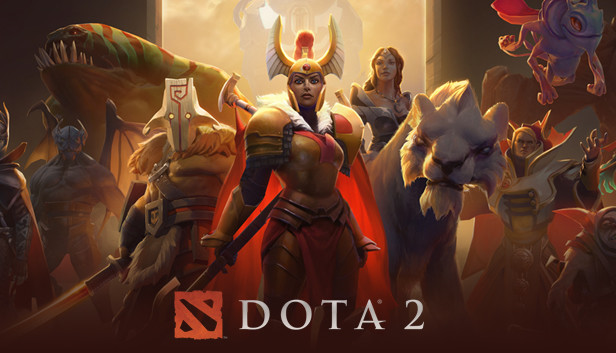

# DOTA 2 <font color = brown> **The International 2022** </font> Analysis
## by Oluwatobi Ajao

## Background

[The International](https://www.dota2.com/newsentry/3398555399425725034) is the vdeo game, **[Dota 2](https://www.dota2.com/home)**'s annual esports world championship tournament hosted and produced by the game's developer [Valve](https://www.valvesoftware.com/en/) which has been held annually since 2011 (with the exception of 2020 due to the COVID-19 pandemic).

The International 2022 (**#TI11**) is the concluding tournament of the Dota Pro Circuit and the eleventh annual edition of The International which returns to Asia for the second time. The invite format is similar to the one used for the preceding International, whereby a point system based on official sponsored Regional Leagues and Majors will be used to determine the teams invited to The International.[[source]](https://en.wikipedia.org/wiki/The_International_(Dota_2))[[source]](https://liquipedia.net/dota2/The_International/2022)

This analysis aims at giving insights into the **TI11** event using different metrics to help us understand how the competition (and all within) fared.

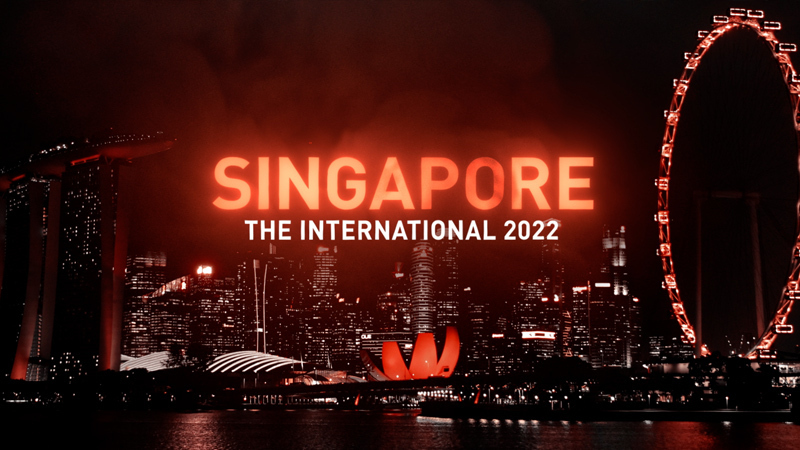

## The Dataset

The [opendota](https://www.opendota.com) is an open source project for the Dota 2 community where Dota 2 data can be gotten for independent analysis. Data on **Heroes**, **Matches**, **Players**, **Leagues** and **Teams** can be gotten either through the:

1. [API](https://www.opendota.com/api-keys) through which developers can build their applications, or the
2. [Data Explorer](https://www.opendota.com/explorer) where advanced queries can be run on PostgreSQL engine

For this analysis, both of these were used. Data was downloaded to csv through running queries on the Data Explorer, and requests were made to the api to generate data within this Jupyter Notebook.

> The objective of this analysis is to examine activities around the TI11 league. There is about [8.5million price](https://liquipedia.net/dota2/The_International/2022) for the 1st place, so why not?
With the available data, we will be examining matches played, top winning teams, heroes pick rate, heroes win rate, highest match duration, highest hero death per match, etc

## Some questions we can answer with the analysis
<a id='research_questions'></a>
1. What are the top winning teams?
2. Which heroes have the highest pick rate?
3. Which heroes have the highest win rate?
4. What is the correlation between players'gold, gold per minute, xp per minute, tower damage and towers killed?
5. Is there a correlation between pick rate and win rate?
6. What matches have the highest duration?
7. Is there a correlation between duration and win rate?
8. Which teams have the highest kill on the average?
9. Which players have the highest kill average?
10. Which teams have the fewest deaths on the average?
11. Which players have the fewest deaths on the average?

### SQL query used to generate data from the Opendota Data Explorer

The data was spooled hours to the end of the tournament.

~~~~
SELECT a.match_id,a.match_seq_num,a.radiant_win,a.start_time,a.duration, 
       a.tower_status_radiant,a.tower_status_dire,a.barracks_status_radiant, 
       a.barracks_status_dire, 
       a.cluster,a.first_blood_time,a.leagueid,a.radiant_team_id,a.dire_team_id, 
       a.radiant_captain,a.dire_captain,a.radiant_score,a.dire_score, 
       a.series_id,b.match_id, 
       b.account_id,b.player_slot,b.hero_id,b.item_0,b.item_1,b.item_2,b.item_3, 
       b.item_4, 
       b.item_5,b.kills,b.deaths,b.assists,b.leaver_status,b.gold,b.last_hits, 
       b.denies, 
       b.gold_per_min,b.xp_per_min,b.gold_spent,b.hero_damage,b.tower_damage, 
       b.hero_healing,b.level,b.stuns,b.obs_placed,b.sen_placed, 
       b.creeps_stacked, 
       b.camps_stacked,b.rune_pickups,b.backpack_0,b.backpack_1,b.backpack_2, 
       b.lane, 
       b.lane_role,b.is_roaming,b.firstblood_claimed,b.teamfight_participation, 
       b.towers_killed,b.roshans_killed,b.observers_placed,b.item_neutral, 
       b.net_worth,c.* 
FROM   (SELECT match_id,match_seq_num,radiant_win,start_time,duration, 
                      tower_status_radiant, 
                      tower_status_dire,barracks_status_radiant, 
               barracks_status_dire, 
                      cluster,first_blood_time,leagueid,radiant_team_id, 
               dire_team_id, 
                      radiant_captain,dire_captain,radiant_score,dire_score, 
               series_id 
        FROM   matches 
        WHERE  leagueid = '14268') a 
       INNER JOIN player_matches b 
               ON a.match_id = b.match_id 
       INNER JOIN heroes c 
               ON b.hero_id = c.id ;
~~~~


> This query spools data from three tables; `matches`, `player_matches` and `heroes`.<br>
We want to generate data for only **The International League 2022 matches** (The `leagueid` is `14268`).<br>
We want to be able to generate the TI11 matches, match activities of each player, and details about the heroes used in these matches.<br>Each match is played by 10 players, 5 each from the radiant and dire teams.


> **Note:** Column names were verbosely used in the query, as this saves both query engine compute resource, and also saves time that would be used to later filter and remove columns during analysis.<br>Also, a little cleanup has been done on Ms Excel. Two columns were added to the table; `win_team` to identify the team that won each match, and `team_type` to let us know which team each player belongs to. Also a `winner_loser` column to help identify players who belong to the winning team. Finally, the different hero roles have been split into 6 different columns.


## Assessment of the Dataset

> Let us view the data and describe its properties. But first things first, we import our packages and data

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import requests
import json
# from pandas import json_normalize
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import datetime as dt
pd.options.mode.chained_assignment = None 

%matplotlib inline

In [2]:
# set DataFrame to display all columns

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("TI2022_matches_.csv")

In [4]:
df.sample(5)

,match_id,match_seq_num,radiant_win,win_team,team_type,winner_loser,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,cluster,first_blood_time,leagueid,radiant_team_id,dire_team_id,radiant_captain,dire_captain,radiant_score,dire_score,series_id,match_id.1,account_id,player_slot,hero_id,item_0,item_1,item_2,item_3,item_4,item_5,kills,deaths,assists,leaver_status,gold,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,hero_healing,level,stuns,obs_placed,sen_placed,creeps_stacked,camps_stacked,rune_pickups,backpack_0,backpack_1,backpack_2,lane,lane_role,is_roaming,firstblood_claimed,teamfight_participation,towers_killed,roshans_killed,observers_placed,item_neutral,net_worth,id,name,localized_name,primary_attr,attack_type,roles,role_1,role_2,role_3,role_4,role_5,role_6,legs
975,6809456477,5702125790,False,dire_win,dire,winner,1665976290,2659,288,1844,62,63,154,10,14268,7732977,7390454,100594231,86799300,17,23,714517,6809456477,86799300,128,103,185,116,38,214,9,36,3,3,15,0,2255,89,3,372,535,13915,14471,598,0,21,40.9198,16,30,20,7,7,0,0,0,3,1,NaN,0,0.739130,1,0,16,638,11930,103,npc_dota_hero_elder_titan,Elder Titan,str,Melee,"Initiator,Disabler,Nuker,Durable",Initiator,Disabler,Nuker,Durable,NaN,NaN,2
2059,6806566779,5699532377,False,dire_win,dire,winner,1665833835,1911,1543,1980,15,63,154,131,14268,350190,7391077,100471531,155332459,7,38,713762,6806566779,339235645,132,14,1,119,116,108,50,125,10,3,14,0,3801,331,12,750,958,23020,21994,8332,0,23,49.1516,0,0,3,1,1,0,0,0,3,1,NaN,1,0.631579,5,1,0,358,22576,14,npc_dota_hero_pudge,Pudge,str,Melee,"Disabler,Initiator,Durable,Nuker",Disabler,Initiator,Durable,Nuker,NaN,NaN,2
231,6816712704,5708639096,True,radiant_win,radiant,winner,1666404316,2348,1844,1536,63,0,154,144,14268,2586976,8599101,183719386,91730177,31,12,715879,6816712704,93618577,1,74,48,1,96,116,110,235,12,0,13,0,2733,382,14,798,931,30545,45674,8301,0,26,90.0893,2,0,1,1,7,65,0,0,2,2,NaN,0,0.806452,3,1,2,289,31083,74,npc_dota_hero_invoker,Invoker,int,Ranged,"Carry,Nuker,Disabler,Escape,Pusher",Carry,Nuker,Disabler,Escape,Pusher,NaN,2
517,6807716914,5700554492,False,dire_win,dire,winner,1665885642,1516,1572,2046,47,63,154,173,14268,8260983,6209166,38628747,183378746,3,27,714098,6807716914,207829314,130,136,216,116,36,50,0,181,6,1,13,0,1495,47,0,334,438,7680,8342,355,1816,14,16.6793,3,5,2,1,5,0,0,0,1,3,NaN,1,0.703704,0,1,3,331,7935,136,npc_dota_hero_marci,Marci,str,Melee,"Support,Carry,Initiator,Disabler,Escape",Support,Carry,Initiator,Disabler,Escape,NaN,2
506,6815355000,5707430420,True,radiant_win,dire,loser,1666339052,2462,1958,0,63,0,154,185,14268,8254400,39,119631156,94155156,22,20,715641,6815355000,154715080,129,106,116,50,77,166,108,216,6,2,10,0,1109,246,4,499,642,18395,35514,386,220,22,64.5285,1,1,0,0,11,41,0,0,2,2,NaN,0,0.800000,0,0,1,361,16304,106,npc_dota_hero_ember_spirit,Ember Spirit,agi,Melee,"Carry,Escape,Nuker,Disabler,Initiator",Carry,Escape,Nuker,Disabler,Initiator,NaN,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 78 columns):
match_id                   2310 non-null int64
match_seq_num              2310 non-null int64
radiant_win                2310 non-null bool
win_team                   2310 non-null object
team_type                  2310 non-null object
winner_loser               2310 non-null object
start_time                 2310 non-null int64
duration                   2310 non-null int64
tower_status_radiant       2310 non-null int64
tower_status_dire          2310 non-null int64
barracks_status_radiant    2310 non-null int64
barracks_status_dire       2310 non-null int64
cluster                    2310 non-null int64
first_blood_time           2310 non-null int64
leagueid                   2310 non-null int64
radiant_team_id            2310 non-null int64
dire_team_id               2310 non-null int64
radiant_captain            2310 non-null int64
dire_captain               2310 non-null int6

In [6]:
df.describe()

,match_id,match_seq_num,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,cluster,first_blood_time,leagueid,radiant_team_id,dire_team_id,radiant_captain,dire_captain,radiant_score,dire_score,series_id,match_id.1,account_id,player_slot,hero_id,item_0,item_1,item_2,item_3,item_4,item_5,kills,deaths,assists,leaver_status,gold,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,hero_healing,level,stuns,obs_placed,sen_placed,creeps_stacked,camps_stacked,rune_pickups,backpack_0,backpack_1,backpack_2,lane,lane_role,firstblood_claimed,teamfight_participation,towers_killed,roshans_killed,observers_placed,item_neutral,net_worth,id,legs
count,2.310000e+03,2.310000e+03,2.310000e+03,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.0,2.310000e+03,2.310000e+03,2.310000e+03,2.310000e+03,2310.000000,2310.000000,2310.000000,2.310000e+03,2.310000e+03,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000
mean,6.810922e+09,5.703443e+09,1.666066e+09,2404.822511,1430.272727,1456.138528,40.510823,44.554113,153.978355,149.783550,14268.0,5.197136e+06,5.681651e+06,1.187418e+08,1.105473e+08,25.056277,25.043290,714724.554113,6.810922e+09,1.614973e+08,66.000000,65.585714,130.409957,148.620346,146.541558,144.960173,134.831602,140.861039,4.954978,5.022944,11.693506,0.040693,2033.101299,214.907792,8.574892,452.076190,554.916450,16368.588745,18904.629004,2818.806061,1152.399567,19.423377,30.057545,3.700000,6.501299,4.916883,1.711688,4.987013,37.617749,26.130303,16.085714,2.015584,2.011255,0.097835,0.650206,1.048052,0.240693,3.700000,529.603896,16266.587013,65.585714,2.104762
std,5.690915e+06,5.098312e+06,3.007863e+05,654.317995,699.588606,714.644250,27.321270,24.477659,0.217189,105.526402,0.0,3.459671e+06,3.396901e+06,4.547002e+07,7.583053e+07,12.039395,11.180547,1081.954616,5.690915e+06,1.183308e+08,64.029484,42.106582,173.624878,202.592374,190.051910,169.788558,148.850624,157.677726,4.214543,3.260841,7.081136,0.197620,2117.741977,167.459999,7.796584,174.996611,175.456404,8679.894816,12739.708598,4731.520793,2639.376410,4.732422,32.335702,4.838272,9.690299,6.568032,1.938865,4.407935,100.481382,88.030788,72.199758,0.910323,0.896001,0.297156,0.149219,1.613561,0.529827,4.838272,242.088660,9356.356053,42.106582,1.340098
min,6.806047e+09,5.699061e+09,1.665801e+09,1071.000000,0.000000,0.000000,0.000000,0.000000,151.000000,0.000000,14268.0,1.500000e+01,1.500000e+01,1.036662e+07,1.036662e+07,3.000000,3.000000,713697.000000,6.806047e+09,1.036662e+07,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,141.000000,163.000000,2840.000000,2226.000000,0.000000,0.000000,7.000000,-19.569800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,649.000000,1.000000,0.000000
25%,6.807773e+09,5.700614e+09,1.665890e+09,1985.000000,1536.000000,1536.000000,3.000000,16.000000,154.000000,73.000000,14268.0,1.838315e+06,2.586976e+06,9.473885e+07,7.231263e+07,15.000000,15.000000,714100.000000,6.807773e+09,9.680308e+07,2.000000,26.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,2.000000,3.000000,6.000000,0.000000,737.250000,68.000000,3.000000,306.000000,420.000000,9943.750000,10334.750000,89.250000,0.000000,16.000000,2.514582,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.556090,0.000000,0

In [7]:
df.shape

(2310, 78)

In [8]:
# Check for duplicated rows

df.duplicated().sum()

0

### Observations from the Assessment

1. The Timestamps in the `start_time` column need to be converted to date
2. The `match_id` and `hero_id` columns are duplicated
3. Some extraneous columns need to be deleted to make the dataset simple and not taking up unnecessary resource

### Dataset Cleanup and Wrangling

> Now we cleanup the observed issues with the dataset

#### Convert timestamps in the `start_time` column to date

In [9]:
# Convert timestamp to datetime, and then strip date from this

df['start_time'] = pd.to_datetime(df['start_time'],
                                  unit='s')

df['start_time'] = df['start_time'].dt.strftime('%d-%m-%Y')

In [10]:
# confirm this is done
df['start_time'].sample(5)

1806    16-10-2022
1698    21-10-2022
2258    15-10-2022
2117    15-10-2022
893     16-10-2022
Name: start_time, dtype: object

#### Remove duplicated columns

> The `hero_id` and `id` columns are same. The `match_id` and `match_id.1` columns are also same

In [11]:
# drop the 'id' and 'match_id.1' columns

df.drop(['id', 'match_id.1'], axis=1, inplace=True)

#### Delete columns not needed for this analysis

In [12]:
# drop unneeded columns

df.drop(['match_seq_num','series_id', 'is_roaming', 'roles'], axis=1, inplace=True)

In [13]:
#Confirm if dropped columns are no more in table

print(df.columns.tolist())

['match_id', 'radiant_win', 'win_team', 'team_type', 'winner_loser', 'start_time', 'duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire', 'cluster', 'first_blood_time', 'leagueid', 'radiant_team_id', 'dire_team_id', 'radiant_captain', 'dire_captain', 'radiant_score', 'dire_score', 'account_id', 'player_slot', 'hero_id', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'kills', 'deaths', 'assists', 'leaver_status', 'gold', 'last_hits', 'denies', 'gold_per_min', 'xp_per_min', 'gold_spent', 'hero_damage', 'tower_damage', 'hero_healing', 'level', 'stuns', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'backpack_0', 'backpack_1', 'backpack_2', 'lane', 'lane_role', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'item_neutral', 'net_worth', 'name', 'localized_name', 'primary_attr', 'attack_type', 'role_1', 'role_2', 'role_3', 'role_4', 'role_

### Structure of Dataset

> Let us now examine the structure of the data

In [14]:
df.head(5)

,match_id,radiant_win,win_team,team_type,winner_loser,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,cluster,first_blood_time,leagueid,radiant_team_id,dire_team_id,radiant_captain,dire_captain,radiant_score,dire_score,account_id,player_slot,hero_id,item_0,item_1,item_2,item_3,item_4,item_5,kills,deaths,assists,leaver_status,gold,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,hero_healing,level,stuns,obs_placed,sen_placed,creeps_stacked,camps_stacked,rune_pickups,backpack_0,backpack_1,backpack_2,lane,lane_role,firstblood_claimed,teamfight_participation,towers_killed,roshans_killed,observers_placed,item_neutral,net_worth,name,localized_name,primary_attr,attack_type,role_1,role_2,role_3,role_4,role_5,role_6,legs
0,6831727836,True,radiant_win,radiant,winner,30-10-2022,2309,1844,256,63,48,154,114,14268,1838315,2163,127617979,72312627,32,23,87278757,0,58,185,63,263,188,36,112,10,2,13,0,4914,189,5,523,695,16930,22565,6675,96,22,0.0000,4,13,0,0,4,0,0,0,3,3,0,0.68750,4,0,4,288,18189,npc_dota_hero_enchantress,Enchantress,int,Ranged,Support,Jungler,Pusher,Durable,Disabler,NaN,4
1,6831727836,True,radiant_win,radiant,winner,30-10-2022,2309,1844,256,63,48,154,114,14268,1838315,2163,127617979,72312627,32,23,111030315,1,7,0,0,1,36,214,102,3,8,18,0,1420,79,5,348,507,10540,20341,94,0,19,106.6510,13,22,3,1,7,0,0,0,1,1,0,0.65625,0,0,13,676,8745,npc_dota_hero_earthshaker,Earthshaker,str,Melee,Support,Initiator,Disabler,Nuker,NaN,NaN,2
2,6831727836,True,radiant_win,radiant,winner,30-10-2022,2309,1844,256,63,48,154,114,14268,1838315,2163,127617979,72312627,32,23,127617979,2,6,249,263,147,116,63,117,13,2,15,0,2392,302,20,639,803,22985,40226,13861,0,23,0.0000,0,0,7,2,3,75,75,38,1,1,1,0.87500,3,1,0,381,23402,npc_dota_hero_drow_ranger,Drow Ranger,agi,Ranged,Carry,Disabler,Pusher,NaN,NaN,NaN,2
3,6831727836,True,radiant_win,radiant,winner,30-10-2022,2309,1844,256,63,48,154,114,14268,1838315,2163,127617979,72312627,32,23,86725175,3,38,635,102,1,244,0,29,2,6,20,0,2770,228,3,452,533,12895,14460,3800,3240,19,42.9892,1,0,8,3,3,0,0,0,3,3,0,0.68750,3,0,1,834,14245,npc_dota_hero_beastmaster,Beastmaster,str,Melee,Initiator,Disabler,Durable,Nuker,NaN,NaN,2
4,6831727836,True,radiant_win,radiant,winner,30-10-2022,2309,1844,256,63,48,154,114,14268,1838315,2163,127617979,72312627,32,23,121769650,4,74,96,1,63,263,65,116,3,5,15,0,2235,291,12,611,797,23505,22384,4072,0,23,41.0700,1,0,0,0,4,0,0,0,2,2,0,0.56250,0,1,1,573,28160,npc_dota_hero_invoker,Invoker,int,Ranged,Carry,Nuker,Disabler,Escape,Pusher,NaN,2


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 72 columns):
match_id                   2310 non-null int64
radiant_win                2310 non-null bool
win_team                   2310 non-null object
team_type                  2310 non-null object
winner_loser               2310 non-null object
start_time                 2310 non-null object
duration                   2310 non-null int64
tower_status_radiant       2310 non-null int64
tower_status_dire          2310 non-null int64
barracks_status_radiant    2310 non-null int64
barracks_status_dire       2310 non-null int64
cluster                    2310 non-null int64
first_blood_time           2310 non-null int64
leagueid                   2310 non-null int64
radiant_team_id            2310 non-null int64
dire_team_id               2310 non-null int64
radiant_captain            2310 non-null int64
dire_captain               2310 non-null int64
radiant_score              2310 non-null int

In [16]:
df.shape

(2310, 72)

In [17]:
print(df['start_time'].unique()) # What period did the competition take place
match_duration = df[['match_id', 'duration']].drop_duplicates()
print(f"\nTotal of {int(match_duration['duration'].sum()/3600)} gameplay hours") # What is the total duration of the matches
print(f"\n{df['match_id'].nunique()} total matches, each match having 10 players")
print(f"\n{df['account_id'].nunique()} players participated in the competition")
print(f"\n{df['radiant_team_id'].append(df['dire_team_id']).nunique()} teams participated in the competition")

['30-10-2022' '22-10-2022' '29-10-2022' '20-10-2022' '23-10-2022'
 '18-10-2022' '15-10-2022' '17-10-2022' '21-10-2022' '16-10-2022']

Total of 154 gameplay hours

231 total matches, each match having 10 players

100 players participated in the competition

20 teams participated in the competition


In [18]:
df.shape

(2310, 72)

### Quick Insights into the Dataset

The dataset shows the **TI11** started on 15th October, and ended on 30th October.<br>
20 teams comprising of 100 players participated in a total of 231 matches.<br>
154 hours of gameplay was acheived.<br>

### My main features of interest in the dataset

1. It is of interest to me to know which heroes help deliver the winnings. In future games, can I predict if these heroes will help me potentially win some dollars.<br>
2. Also, which ~~villains~~ heroes were possibly agents of downfall to teams/players so I can avoid them altogether in the future.<br>
3. Which winning teams are spending the most time in a match?<br>
4. Finally, if it would be possible, I will love to celebrate the winning teams/players, delve deep into their match data and stats maybe I could see/learn some pattern that can help me also win in the future. I will also like to check their performance in the previous league<br>

### Answering the research questions

> In this section, we attempt to answer the questions earlier outlined <a href="#research_questions">here</a>


### 1. What are the top winning teams?

In [19]:
# Add a new column that gives the winning team_id

df['win_team_id'] = np.where(df['win_team']== 'radiant_win', df['radiant_team_id'], df['dire_team_id'])

winning_team = df[['match_id', 
'win_team', 
'radiant_team_id', 
'dire_team_id', 'win_team_id']].drop_duplicates()


In [20]:
# The top 5 winning teams

df.groupby('win_team_id')['match_id'].nunique().sort_values(ascending=False).nlargest(5)

win_team_id
8291895    23
2163       22
1838315    20
15         15
6209166    15
Name: match_id, dtype: int64

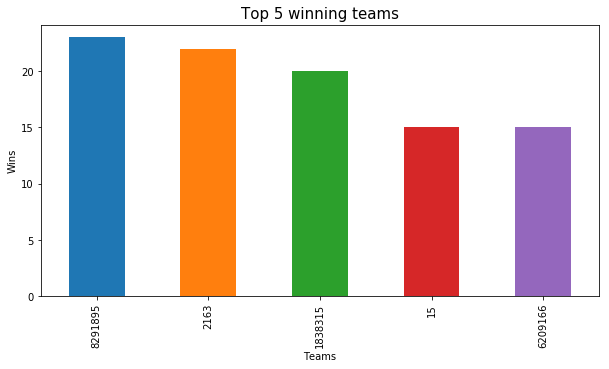

In [21]:
# Plot bar chart of the top 5 winning teams

fig = plt.figure(figsize=(10,5))
df.groupby('win_team_id')['match_id'].nunique().sort_values(ascending=False).nlargest(5).plot(kind='bar')
plt.title("Top 5 winning teams",fontsize=15)
plt.ylabel("Wins")
plt.xlabel("Teams"); 

In [22]:
# Extract information about the winner
winner_team_url = "https://api.opendota.com/api/teams/8291895"

winner_team_request = requests.get(winner_team_url)

winner_team_data = json.loads(winner_team_request.text)

print(winner_team_data)

{'team_id': 8291895, 'rating': 1624.51, 'wins': 169, 'losses': 98, 'last_match_time': 1667130565, 'name': 'Tundra Esports', 'tag': 'Tundra', 'logo_url': 'https://steamusercontent-a.akamaihd.net/ugc/1771573722041415896/D98163DE6281550D35494CEFDF6257F9716BD43B/'}


### <font color = brown> _Insights_ </font>

> Team (Tundra) is the winner of the league, with a price of $8.5million!

> Team Tundra won 23 games in the league, closely followed by Teams Liquid and Secret<br>Overall, Tundra has won 169 games in Dota 2 with 98 losses.
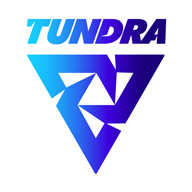



### 2. Which heroes were picked most?

In [23]:
pick_rate = df[['match_id', 
'hero_id']].drop_duplicates()

In [24]:
df.groupby('hero_id')['match_id'].nunique().sort_values(ascending=False).nlargest(5)

hero_id
136    95
19     82
11     81
52     77
85     72
Name: match_id, dtype: int64

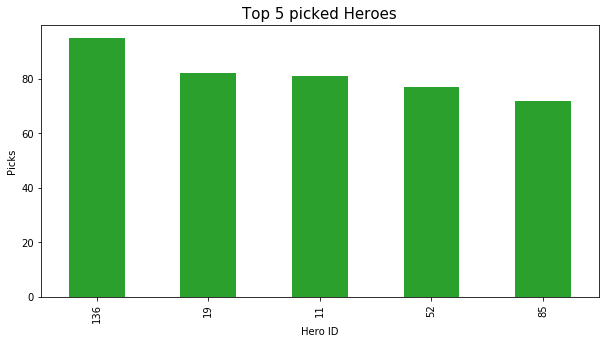

In [25]:
fig = plt.figure(figsize=(10,5))
df.groupby('hero_id')['match_id'].nunique().sort_values(ascending=False).nlargest(5).plot(kind='bar',
                                                                                          color=sns.color_palette()[2])
plt.title("Top 5 picked Heroes",fontsize=15)
plt.ylabel("Picks")
plt.xlabel("Hero ID"); 

In [26]:
# Extract information about the hero
hero_136 = df[['hero_id','localized_name', 'role_1', 'role_2', 'role_3', 'role_4', 'role_5', 'role_6']][df['hero_id'] == 136].drop_duplicates()

hero_136

,hero_id,localized_name,role_1,role_2,role_3,role_4,role_5,role_6
16,136,Marci,Support,Carry,Initiator,Disabler,Escape,NaN


### <font color = brown> _Insights_ </font>

> Marci was the most picked hero<br>
Yeah, Marci does have the 'dangerous' smile 😊<br>
> Let's see if this smile is just aesthetics, or it fetches some good wins

> Marci's core roles are support, Carry, Initiator, Disabler and Escape

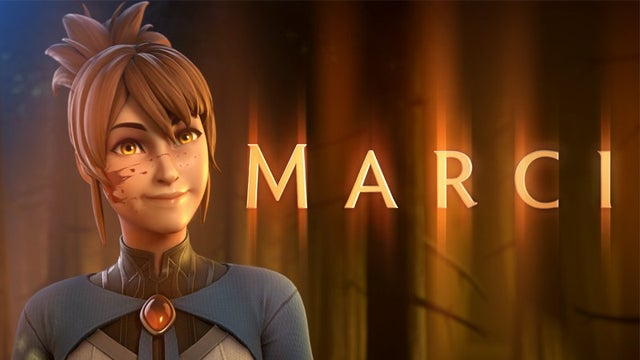

### 3. Which heroes have the highest match wins?

> Win rate in percentage is calculated by: <br>
$$
\frac{Matches \,won}{Total \,matches}*100
$$


In [27]:
win_rate_df = pd.read_csv("win_rate.csv")

In [28]:
win_rate_df.sample(5)

,hero_id,loser,winner,win_rate
31,34,1,1,0.43
108,126,7,2,0.87
86,96,6,5,2.16
96,107,3,5,2.16
11,12,2,1,0.43


In [29]:
win_rate_df['win_rate'].sort_values(ascending=False).nlargest(5)

112    20.35
47     19.05
18     18.61
10     17.32
4      16.45
Name: win_rate, dtype: float64

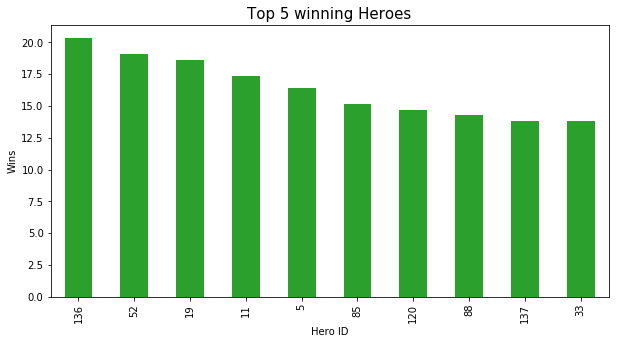

In [30]:
fig = plt.figure(figsize=(10,5))
win_rate_df.groupby('hero_id')['win_rate'].sum().sort_values(ascending=False).nlargest(10).plot(kind='bar',
                                                                                          color=sns.color_palette()[2])
plt.title("Top 5 winning Heroes",fontsize=15)
plt.ylabel("Wins")
plt.xlabel("Hero ID"); 

In [31]:
# Extract information about the hero
hero_win = win_rate_df[win_rate_df['win_rate'] == 20.35]

hero_win

,hero_id,loser,winner,win_rate
112,136,48,47,20.35


### <font color = brown> _Insights_ </font>

> Once again, Marci appears not to only be the preferred choice, but also the popular choice amongst winning players within the period<br> <br>
> We now have some degree of confidence in infering that Marci is a popular and good choice of hero among players.


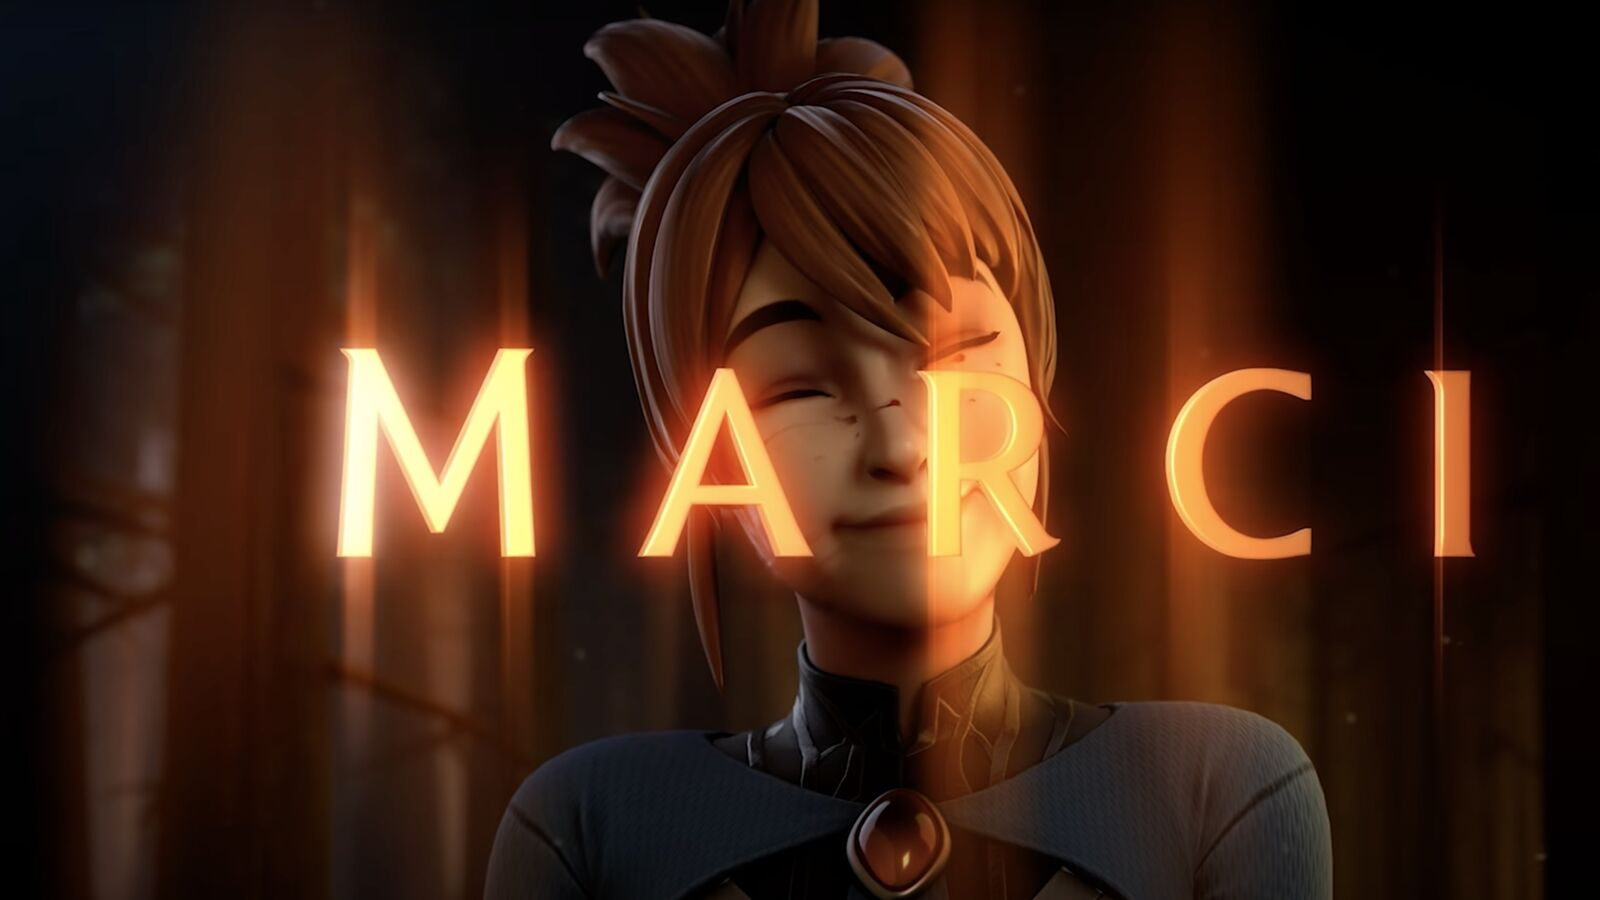

### 4.  What is the correlation between players' gold, gold per minute, xp per minute, tower damage and towers killed?

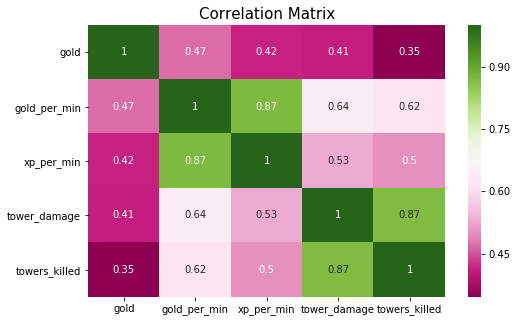

In [44]:
# A correlation will be measured between gold, gold per minute, xp per minute, tower damage and towers killed

corr_matrix = ['gold', 'gold_per_min', 'xp_per_min', 'tower_damage', 'towers_killed']
plt.figure(figsize=(8,5))
sns.heatmap(df[corr_matrix].corr(),cmap="PiYG", annot = True)
plt.title("Correlation Matrix", size = 15);

### <font color = brown> _Insights_ </font>

The correlation matrix shows that there is a strong positive correlation between the gold per min and towers killed, xp per minute and tower damage. This is so because as a player damages and kills a tower, the gold earned increases more. Also, an increase in the damage to a tower eventually leads to the killing of such tower.